In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv()

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    model='deepseek-chat',
                    openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    openai_api_base="https://api.deepseek.com/v1",
                    # model='gpt-4o-mini',
                    # openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    # openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )


from langgraph.store.memory import InMemoryStore

# Create store with semantic search enabled
store = InMemoryStore(
    index={
        "embed": embedding,
        "dims": 1536,
    }
)

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Store some memories
store.put(("user_123", "memories"), "1", {"text": "I love pizza"})
store.put(("user_123", "memories"), "2", {"text": "I prefer Italian food"})
store.put(("user_123", "memories"), "3", {"text": "I don't like spicy food"})
store.put(("user_123", "memories"), "3", {"text": "I am studying econometrics"})
store.put(("user_123", "memories"), "3", {"text": "I am a plumber"})

In [3]:
# Find memories about food preferences
memories = store.search(("user_123", "memories"), query="I like food?", limit=5)

for memory in memories:
    print(f'Memory: {memory.value["text"]} (similarity: {memory.score})')

Memory: I prefer Italian food (similarity: 0.46490621117217473)
Memory: I love pizza (similarity: 0.35754608768288904)
Memory: I am a plumber (similarity: 0.2555201083697055)


# Using in your agent

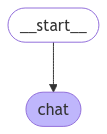

In [4]:
from typing import Optional
from langgraph.store.base import BaseStore

from langgraph.graph import START, MessagesState, StateGraph



def chat(state, *, store: BaseStore):
    # Search based on user's last message
    items = store.search(
        ("user_123", "memories"), query=state["messages"][-1].content, limit=2
    )
    memories = "\n".join(item.value["text"] for item in items)
    memories = f"## Memories of user\n{memories}" if memories else ""
    response = model.invoke(
        [
            {"role": "system", "content": f"You are a helpful assistant.\n{memories}"},
            *state["messages"],
        ]
    )
    return {"messages": [response]}


builder = StateGraph(MessagesState)
builder.add_node(chat)
builder.add_edge(START, "chat")
graph = builder.compile(store=store)
graph

In [5]:
for message, metadata in graph.stream(
    input={"messages": [{"role": "user", "content": "I'm hungry"}]},
    stream_mode="messages",
):
    print(message.content, end="")

It sounds like you're in the mood for something delicious! Since you love Italian food, how about ordering a pizza? You could go for your favorite toppings or try something new. Let me know if you need any recommendations!

# Using in create_react_agent

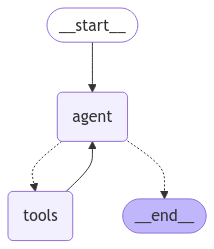

In [6]:
import uuid
from typing import Optional

from langchain_core.tools import InjectedToolArg
from langgraph.store.base import BaseStore
from typing_extensions import Annotated

from langgraph.prebuilt import create_react_agent


def prepare_messages(state, *, store: BaseStore):
    # Search based on user's last message
    items = store.search(
        ("user_123", "memories"), query=state["messages"][-1].content, limit=2
    )
    memories = "\n".join(item.value["text"] for item in items)
    memories = f"## Memories of user\n{memories}" if memories else ""
    return [
        {"role": "system", "content": f"You are a helpful assistant.\n{memories}"}
    ] + state["messages"]


# You can also use the store directly within a tool!
def upsert_memory(
    content: str,
    *,
    memory_id: Optional[uuid.UUID] = None,
    store: Annotated[BaseStore, InjectedToolArg],
):
    """Upsert a memory in the database."""
    # The LLM can use this tool to store a new memory
    mem_id = memory_id or uuid.uuid4()
    store.put(
        ("user_123", "memories"),
        key=str(mem_id),
        value={"text": content},
    )
    return f"Stored memory {mem_id}"


agent = create_react_agent(
    model,
    tools=[upsert_memory],
    # The state_modifier is run to prepare the messages for the LLM. It is called
    # right before each LLM call
    state_modifier=prepare_messages,
    store=store,
)

agent

In [7]:
for message, metadata in agent.stream(
    input={"messages": [{"role": "user", "content": "I'm hungry"}]},
    stream_mode="messages",
):
    print(message.content, end="")

Given your preferences, it sounds like you might enjoy some Italian food! Since you love pizza, how about ordering a delicious pizza? There are so many options to choose from—you could go for a classic Margherita, a meat-lover's pizza, or even something with a unique twist like a BBQ chicken pizza. What would you prefer?